In [1]:
import psycopg2
import pandas as pd 
# from sqlalchemy.types import Integer, Text, String, DateTime
import sqlalchemy as s
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = s.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
repo_list = pd.DataFrame()
repo_list_query = f"""
SELECT repo_id, repo_name, repo_path from repo
WHERE repo_name = 'concourse' OR repo_name = 'postfacto' or repo_name = 'clarity' or repo_name = 'gpdb' or
      repo_name = 'kpack' or repo_name = 'rabbitmq-server' or repo_name = 'sonobuoy' or repo_name = 'velero' 
      or repo_name = 'octant' or repo_name = 'gpdb' or repo_name = 'tern' or repo_name = 'salt'
      or repo_name = 'charts' or repo_name = 'pivotal-partner-platform-architecture' or repo_name = 'cf-rabbitmq-release';
    """
repo_list = pd.read_sql_query(repo_list_query, con=engine)
print(repo_list)

    repo_id            repo_name                              repo_path
0     26235            concourse               github.com/pcfdev-forks/
1     25857                 gpdb               github.com/greenplum-db/
2     28031               velero               github.com/vmware-tanzu/
3     30039               charts                    github.com/bitnami/
4     26983            postfacto                    github.com/pivotal/
5     28030             sonobuoy               github.com/vmware-tanzu/
6     28051            concourse                  github.com/concourse/
7     30904            concourse             github.com/CloudPipelines/
8     26600                 gpdb  github.com/Pivotal-Field-Engineering/
9     27913              clarity                     github.com/vmware/
10    27235  cf-rabbitmq-release                 github.com/pivotal-cf/
11    27043                kpack                    github.com/pivotal/
12    26232  cf-rabbitmq-release               github.com/pcfdev

In [4]:
## List of repository IDs for the report
#repo_dict = {25760, 25663} #spring-boot & spring-framework
#repo_dict = {28051} # concourse
#repo_dict = {26983} #postfacto
#repo_dict = {25432} #rabbitmq-server
#repo_dict = {25663} #spring-framework
#repo_dict = {28030} #sonobuoy
#repo_dict = {28031} #velero
#repo_dict = {27913} #clarity
#repo_dict = {28037} #octant
#repo_dict = {25857} #gpdb
repo_dict = {30932} #salt

In [5]:
#from datetime import date
import datetime 

current = datetime.date.today()
today = "'" + str(current) + "'"
#print(current)

first_current = current.replace(day=1)
last_month = first_current - datetime.timedelta(days=1)
end_date = "'" + str(last_month) + "'"
print(end_date)

start = last_month - datetime.timedelta(days=365)
start_date = "'" + str(start) + "'"
print(start_date)



'2021-01-31'
'2020-02-01'


In [6]:
from datetime import datetime, timezone

end_dt = datetime.strptime(end_date, "'%Y-%m-%d'").replace(tzinfo=timezone.utc)
print(end_dt)

start_dt = datetime.strptime(start_date, "'%Y-%m-%d'").replace(tzinfo=timezone.utc)
print(start_dt)



2021-01-31 00:00:00+00:00
2020-02-01 00:00:00+00:00


In [7]:
from datetime import datetime, timedelta, timezone

#now = datetime.now(timezone.utc)
#current = now.replace(hour=0, minute=0, second=0, microsecond=0)

#end_dt = current.replace(day=1) - timedelta(days=1)
print(end_dt)

#start_dt = end_dt - timedelta(days=365)
print(start_dt)

2021-01-31 00:00:00+00:00
2020-02-01 00:00:00+00:00


In [17]:
########### EXPERIMENTAL

#Commit data - from humans excluding known bots
commitsDF = pd.DataFrame()
commitsquery = f"""
                SELECT
                    DISTINCT(cmt_commit_hash),
                    contributors.cntrb_canonical,
                    canonical_full_names.cntrb_full_name AS canonical_full_name,
                    cmt_author_name, cmt_author_email, repo_id, cmt_author_timestamp 
                FROM commits 
                    LEFT OUTER JOIN contributors ON cntrb_email = cmt_author_email left outer join 
                    (
                        SELECT distinct on (cntrb_canonical) cntrb_full_name, cntrb_canonical, data_collection_date
                        FROM contributors
                        WHERE cntrb_canonical = cntrb_email
                        order by cntrb_canonical
                    ) canonical_full_names on canonical_full_names.cntrb_canonical = contributors.cntrb_canonical
                WHERE 
                    repo_id = {value}
                    AND cmt_author_name NOT LIKE 'snyk%%'
                    AND cmt_author_name NOT LIKE '%%bot'
                    AND cmt_author_name NOT LIKE '%%Bot'
                    AND cmt_author_name NOT LIKE '%%BOT'
                    AND cmt_author_name NOT LIKE 'dependabot%%'
                    AND cmt_author_name NOT LIKE 'gerrit%%'
                    AND cmt_author_name NOT LIKE '%%utomation%%'
                    AND cmt_author_name NOT LIKE '%%ipeline%%'
                    AND cmt_author_name NOT LIKE '%%Cloud Foundry%%'
                    AND cmt_author_name != 'cfcr'
                    AND cmt_author_name != 'CFCR'
                    AND cmt_author_name != 'Travis CI'
                    AND cmt_author_name != 'Bitnami Containers'
                    AND cmt_author_name != 'Cloud Foundry London'
                    AND cmt_author_name != 'Spring Operator'
                    AND cmt_author_name != 'Spring Buildmaster'
                    AND cmt_author_name != 'pivotal-rabbitmq-ci'
                ORDER BY
                    cntrb_canonical;
                """

all_commitsDF = pd.read_sql_query(commitsquery, con=engine)
commitsDF = all_commitsDF[(all_commitsDF['cmt_author_timestamp'] >= start_dt) & (all_commitsDF['cmt_author_timestamp'] <= end_dt)]
total_commits = commitsDF.cmt_commit_hash.nunique()

authorDF = pd.DataFrame()
authorDF = commitsDF.cntrb_canonical.value_counts()
authorDF = authorDF.reset_index()
authorDF.columns = ['name', 'commits']
authorDF['percent'] = authorDF['commits'] / total_commits

print(authorDF.head(10))

                                  name  commits   percent
0                    pedro@algarvio.me      927  0.223589
1                 gareth@saltstack.com      161  0.038833
2                  erik@erikjohnson.ca       99  0.023878
3                    bdrung@debian.org       60  0.014472
4                    krion@freebsd.org       15  0.003618
5                math.parent@gmail.com        9  0.002171
6                       lukas@raska.me        6  0.001447
7       sebastien.lawniczak@orange.com        4  0.000965
8                           mc@suse.de        3  0.000724
9  pair+grosenhouse+slevine@pivotal.io        2  0.000482


In [8]:
#Commit data - from humans excluding known bots
commitsDF = pd.DataFrame()
for value in repo_dict: 
    commitsquery = f"""
                    SELECT
                        DISTINCT(cmt_commit_hash),
                        contributors.cntrb_canonical,
                        canonical_full_names.cntrb_full_name AS canonical_full_name,
                        cmt_author_name, cmt_author_email, repo_id, cmt_author_timestamp 
                    FROM commits 
                        LEFT OUTER JOIN contributors ON cntrb_email = cmt_author_email left outer join 
                        (
                            SELECT distinct on (cntrb_canonical) cntrb_full_name, cntrb_canonical, data_collection_date
                            FROM contributors
                            WHERE cntrb_canonical = cntrb_email
                            order by cntrb_canonical
                        ) canonical_full_names on canonical_full_names.cntrb_canonical = contributors.cntrb_canonical
                    WHERE
                        repo_id = {value}
                        AND cmt_author_name NOT LIKE '%%utomation%%'
                        AND cmt_author_name NOT LIKE '%%ipeline%%'
                        AND cmt_author_name NOT LIKE '%%Cloud Foundry%%'
                        AND cmt_author_name NOT LIKE 'snyk%%'
                        AND cmt_author_name NOT LIKE '%%bot'
                        AND cmt_author_name NOT LIKE 'dependabot%%'
                        AND cmt_author_name NOT LIKE '%%Bot'
                        AND cmt_author_name NOT LIKE '%%BOT'
                        AND cmt_author_name != 'cfcr'
                        AND cmt_author_name != 'CFCR'
                        AND cmt_author_name != 'Travis CI'
                        AND cmt_author_name != 'Cloud Foundry London'
                        AND cmt_author_name != 'pivotal-rabbitmq-ci'
                        AND cmt_author_name != 'Bitnami Containers'
                        AND cmt_author_name != 'Spring Operator'
                        AND cmt_author_name != 'Spring Buildmaster'
--                      AND cmt_author_timestamp >= {start_date}
--                      AND cmt_author_timestamp <= {end_date}
                    ORDER BY
                        cntrb_canonical;
                    """
    
    get_repo_name_query = f"""
        SELECT repo_name from repo where repo_id = {value};
           """
    get_repo_name = pd.read_sql_query(get_repo_name_query, con=engine)
    repo_name = get_repo_name.repo_name[0]
    
all_commitsDF = pd.read_sql_query(commitsquery, con=engine)
commitsDF = all_commitsDF[(all_commitsDF['cmt_author_timestamp'] > start_dt) & (all_commitsDF['cmt_author_timestamp'] < end_dt)]
total_commits = commitsDF.cmt_commit_hash.nunique()  

In [9]:
authorDF = pd.DataFrame()
authorDF = commitsDF.cntrb_canonical.value_counts()
authorDF = authorDF.reset_index()
authorDF.columns = ['email', 'commits']
authorDF['percent'] = authorDF['commits'] / total_commits
print(authorDF.head(10))
print()

                                 email  commits   percent
0                    pedro@algarvio.me      927  0.223589
1                 gareth@saltstack.com      161  0.038833
2                  erik@erikjohnson.ca       99  0.023878
3                    bdrung@debian.org       60  0.014472
4                    krion@freebsd.org       15  0.003618
5                math.parent@gmail.com        9  0.002171
6                       lukas@raska.me        6  0.001447
7       sebastien.lawniczak@orange.com        4  0.000965
8                           mc@suse.de        3  0.000724
9  pair+grosenhouse+slevine@pivotal.io        2  0.000482



In [18]:
authorDF = pd.DataFrame()
#authorDF = commitsDF.canonical_full_name.value_counts()
authorDF = commitsDF.cmt_author_name.value_counts()
authorDF = authorDF.reset_index()
authorDF.columns = ['name', 'commits']
authorDF['percent'] = authorDF['commits'] / total_commits
print(authorDF.head(10))

                  name  commits   percent
0       Pedro Algarvio     1854  0.447178
1       Daniel Wozniak      422  0.101785
2             twangboy      273  0.065847
3         Erik Johnson      211  0.050892
4  Gareth J. Greenaway      196  0.047274
5     Christian McHugh      153  0.036903
6     Cédric Bosdonnat      125  0.030150
7    Daniel A. Wozniak      121  0.029185
8       Benjamin Drung      120  0.028944
9      Dmitry Kuzmenko      105  0.025326


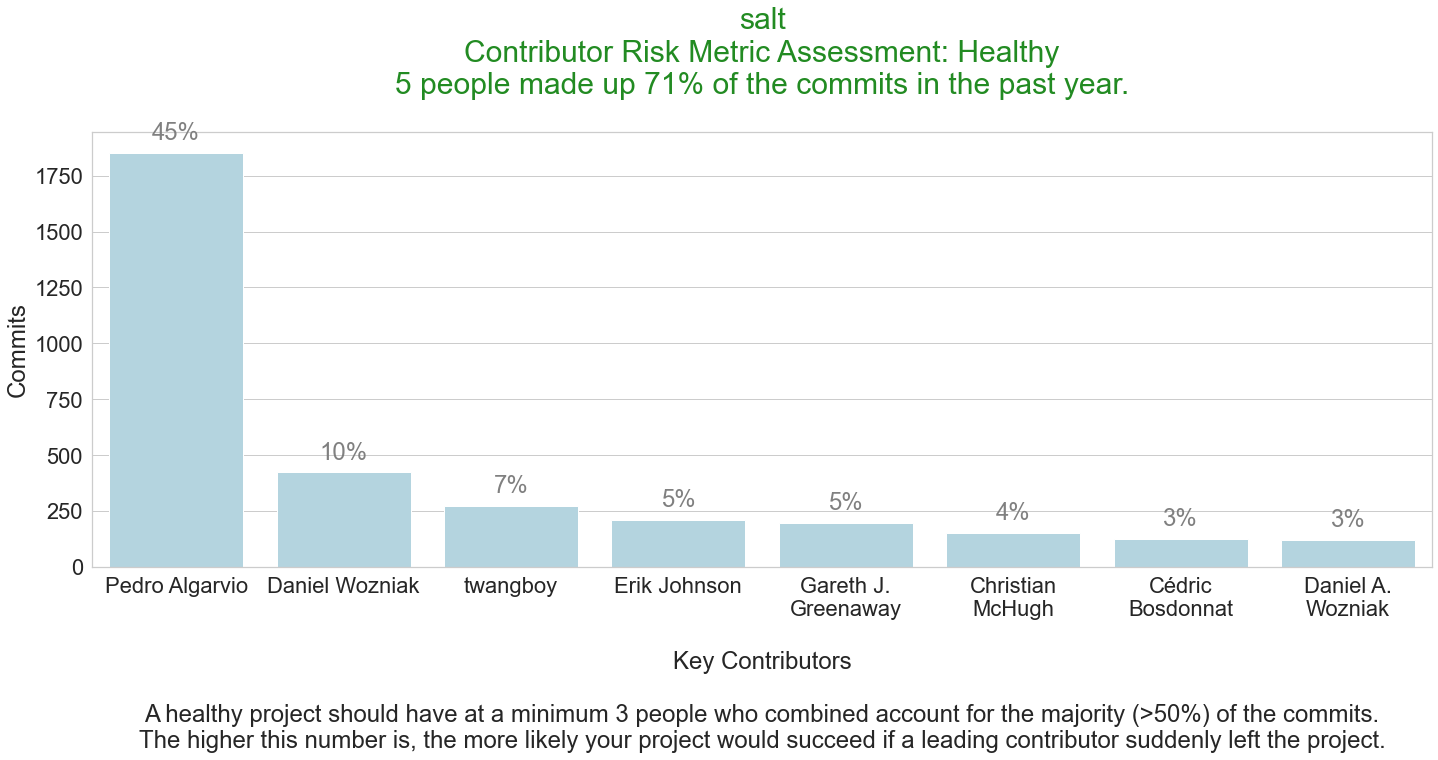

In [11]:
import textwrap

cum_percent = 0
people_list = []

i = 1
num_people = 0

for item in authorDF.iterrows():
    name = item[1]['name']
    percent = item[1]['percent']
    commits = item[1]['commits']
    
    cum_percent += percent
    
    people_list.append([name, percent, commits])
    
    if (cum_percent > .70 and num_people == 0):
        num_people = i
        risk_percent = cum_percent
        
    if i == 8:
        if cum_percent <= .70:
            risk_percent = cum_percent
            num_people = i
        break
    i+=1
    
risk_list = []
bar_colors = []

j = 1
for person in people_list:
    name = person[0]
    if len(name) > 15:
        new_name = textwrap.wrap(name, 15)
        name = '\n'.join(new_name)
    percent = person[1]
    commits = person[2]
    risk_list.append([name, percent, commits])
    
    if (num_people < 3 and j <= num_people):
        bar_colors.append('red')
    else:
        bar_colors.append('lightblue')
    
    j+=1
    

names = [item[0] for item in risk_list]
percents = [item[1] for item in risk_list]
commits = [item[2] for item in risk_list]

sns.set_style('ticks')
sns.set(style="whitegrid", font_scale=2)

fig, ax = plt.subplots()

# the size of A4 paper
fig.set_size_inches(24, 8)

title = repo_name + "\nContributor Risk Metric Assessment: "

if num_people < 3:
    title += "AT RISK"
    title_color = 'firebrick'
else:
    title += "Healthy"
    title_color = 'forestgreen'
title += "\n" + str(num_people) + " people made up " + "{:.0%}".format(risk_percent) + " of the commits in the past year.\n"

risk_bar = sns.barplot(x=names, y=commits, palette=bar_colors).set_title(title, fontsize=30, color=title_color)

risk_bar_labels = ax.set_xticklabels(names, wrap=True)
risk_bar_labels = ax.set_ylabel('Commits')
risk_bar_labels = ax.set_xlabel('\nKey Contributors\n\nA healthy project should have at a minimum 3 people who combined account for the majority (>50%) of the commits.\nThe higher this number is, the more likely your project would succeed if a leading contributor suddenly left the project.')

i = 0
for p in ax.patches:
    ax.annotate("{:.0%}".format(percents[i]), (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', color='gray', xytext=(0, 20),
        textcoords='offset points')
    i+=1


In [12]:
from pathlib import Path
Path("output/tmp/tmp2").mkdir(parents=True, exist_ok=True)
fig.savefig('output/tmp/tmp2/test1.png')

## Misc data exploration
Trying to understand what's happening with the multiple canonical names

In [42]:
test = commitsDF.loc[commitsDF['cntrb_canonical'] == 'jrosland@vmware.com'].canonical_full_name
print(test[402])

Jonas Rosland


In [48]:
commitsDF.loc[commitsDF['cntrb_canonical'] == 'bryanliles@gmail.com']

,cmt_commit_hash,cntrb_canonical,canonical_full_name,cmt_author_name,cmt_author_email,repo_id,cmt_author_timestamp
28,005fba92f6b43beab5b788c4803c154da87160f1,bryanliles@gmail.com,bryanl,bryanl,bryanliles@gmail.com,28037,2019-04-04 00:09:16+00:00
29,00b5c25e697375d3a58c0eabcfb53e878ab6f060,bryanliles@gmail.com,Bryan Liles,Bryan Liles,bryanliles@gmail.com,28037,2019-04-18 19:07:00+00:00
30,00fac7d8aa415772fdbd69af800a4b36e98865a2,bryanliles@gmail.com,bryanl,bryanl,bryanliles@gmail.com,28037,2019-08-03 13:51:51+00:00
31,02c9ffaa4350b832aca7dd050911ea24d2bd9cbf,bryanliles@gmail.com,lilesb,lilesb,bryanliles@gmail.com,28037,2019-09-15 20:23:59+00:00
32,02e4c929af1e21cfb45774804ff5e94a018a6aa4,bryanliles@gmail.com,bryanl,bryanl,bryanliles@gmail.com,28037,2019-06-11 18:51:13+00:00
...,...,...,...,...,...,...,...
377,fc3a26d05f70cb2be80246d5f8ea26562fb03976,bryanliles@gmail.com,bryanl,bryanl,bryanliles@gmail.com,28037,2019-03-13 19:26:45+00:00
378,fcb5a2ca48210c6c108cb165421fcdfdc88c5b29,bryanliles@gmail.com,Bryan Liles,Bryan Liles,bryanliles@gmail.com,28037,2020-02-20 14:07:57+00:00
379,fd44145165a6e47f86d3e51bc9536130cd019258,bryanliles@gmail.com,Bryan Liles,Bryan Liles,bryanliles@gmail.com,28037,2019-04-08 16:09:13+00:00
380,fe36a3665e587de53f20cf551e86729f9066b972,bryanliles@gmail.com,Bryan Liles,Bryan Liles,bryanliles@gmail.com,28037,2019-07-22 17:11:18+00:00
